In [3]:
import torch
import warnings
warnings.filterwarnings('ignore')
torch.set_default_tensor_type(torch.DoubleTensor)
import random
import math
import torch.nn as nn
from torch.nn import functional as F
from collections import defaultdict
import torch
from mingpt.utils import CfgNode as CN
from tqdm.auto import tqdm
torch.set_default_tensor_type(torch.DoubleTensor)
import scanpy as sc
from torch.utils.data import (DataLoader, Dataset)
import numpy as np
import os
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# 定义一些分类模型
models = {
    'Logistic Regression': LogisticRegression(random_state=2024),
    'Decision Tree': DecisionTreeClassifier(random_state=2024),
    'Random Forest': RandomForestClassifier(random_state=2024),
    'SVM_linear': SVC(decision_function_shape="ovr", kernel="linear", random_state=2024),
    'SVM_rbf': SVC(decision_function_shape="ovr", kernel="rbf", random_state=2024),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}


def same_seeds(seed):
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


same_seeds(2024)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                             .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)
        # print("B, T, C",B, T, C)
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        # print("q, k, v",q, k, v)
        q = F.relu(q)
        k = F.relu(k)
        v = F.relu(v)

        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float('-inf'))
        # att = F.softmax(att, dim=-1)
        att = F.relu(att)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)  # re-assemble all head outputs side by side

        y = self.resid_dropout(self.c_proj(y))
        return y

class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc=nn.Linear(config.n_embd, 2 * config.n_embd),
            c_proj=nn.Linear(2 * config.n_embd, config.n_embd),
            act=nn.ReLU(),
            dropout=nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))  # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x

class scDataSet(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        data = torch.from_numpy(self.data)
        label = torch.from_numpy(self.label)

        x = torch.tensor(data[idx])
        y = torch.tensor(label[idx])
        return x, y

class GPT(nn.Module):

    @staticmethod
    def get_default_config():
        C = CN()
        # either model_type or (n_layer, n_head, n_embd) must be given in the config
        C.model_type = 'gpt'
        C.n_layer = None
        C.n_head = None
        C.n_embd = None
        # these options must be filled in externally
        C.vocab_size = None
        C.block_size = None
        # dropout hyperparameters
        C.embd_pdrop = 0.1
        C.resid_pdrop = 0.1
        C.attn_pdrop = 0.1
        C.entreg = .1
        C.p = 2
        C.h = 2
        C.loss1 = 50
        C.mod2_dim = 134
        return C

    def __init__(self, config):
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size
        self.conf = config
        type_given = config.model_type is not None
        params_given = all([config.n_layer is not None, config.n_head is not None, config.n_embd is not None])
        assert type_given ^ params_given  # exactly one of these (XOR)
        if type_given:
            # translate from model_type to detailed configuration
            config.merge_from_dict({
                                       # names follow the huggingface naming conventions
                                       # GPT-1
                                       'openai-gpt': dict(n_layer=12, n_head=12, n_embd=768),  # 117M params
                                       # GPT-2 configs
                                       'gpt2': dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
                                       'gpt2-medium': dict(n_layer=24, n_head=16, n_embd=1024),  # 350M params
                                       'gpt2-large': dict(n_layer=36, n_head=20, n_embd=1280),  # 774M params
                                       'gpt2-xl': dict(n_layer=48, n_head=25, n_embd=1600),  # 1558M params
                                       # Gophers
                                       'gopher-44m': dict(n_layer=8, n_head=16, n_embd=512),
                                       # (there are a number more...)
                                       # I made these tiny models up
                                       'gpt-mini': dict(n_layer=6, n_head=6, n_embd=192),
                                       'gpt-micro': dict(n_layer=4, n_head=4, n_embd=128),
                                       'gpt-nano': dict(n_layer=1, n_head=config.h, n_embd=config.n_embd),
                                   }[config.model_type])
        print("config.vocab_size, config.n_embd", config.vocab_size, config.n_embd)
        self.pro = nn.Linear(config.vocab_size, config.n_embd)
        self.transformer = nn.ModuleDict(dict(
            wpe=nn.Embedding(config.block_size, config.n_embd),
            drop=nn.Dropout(config.embd_pdrop),
            h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f=nn.LayerNorm(config.n_embd),
        ))  # config.n_embd*config.block_size
        # self.lm_head = nn.Linear(config.n_embd, config.mod2_dim, bias=False)
        self.lm_head = nn.Linear(config.n_embd, config.mod2_dim)  # , bias=False
        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02 / math.sqrt(2 * config.n_layer))

        # # report number of parameters (note we don't count the decoder parameters in lm_head)
        # n_params = sum(p.numel() for p in self.transformer.parameters())
        # print("number of parameters: %.2fM" % (n_params / 1e6,))

    def cross_mod(self, mod1, mod2=None):
        idx = torch.tensor(mod1, dtype=torch.double)
        device = idx.device
        b, t, v = idx.size()
        num_cls = int(self.conf.block_size/2)
        cls1 = torch.zeros(num_cls).long().to(device)
        cls2 = torch.ones(num_cls).long().to(device)
        cls = torch.cat((cls1, cls2), dim=0).to(device)
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0)

        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (1, t, n_embd)
        cls_emb = self.transformer.wpe(cls) # + cls_emb

        x = self.transformer.drop(idx + pos_emb) # + cls_emb
        for block in self.transformer.h:
            x = F.relu(x)
            x = block(x)
        x = F.relu(x)
        x = self.transformer.ln_f(x)
        x = F.relu(x)
        x = torch.mean(x, dim=1)
        emb = x
        logits = self.lm_head(x)
        mod_logits = F.relu(logits)

        # if we are given some desired targets also calculate the loss
        loss = None
        # criterion = nn.CrossEntropyLoss()

        if mod2 is not None:
            targets = torch.tensor(mod2, dtype=torch.double)
            loss1 = F.mse_loss(mod_logits, targets) ** 0.5
            loss = loss1  # loss1 #+ loss2
        return loss, emb,mod_logits

    def forward(self, X, Y):

        loss1, emb_mod,mod1_logits2 = self.cross_mod(X, Y)

        loss = self.conf.loss1*loss1
        return emb_mod, loss,mod1_logits2

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)

    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear,)
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn  # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params),)
        assert len(
            param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params),)

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas) #,weight_decay=train_config.weight_decay
        return optimizer


from typing import Tuple
import scipy


def foscttm(
        x: np.ndarray, y: np.ndarray, **kwargs
) -> Tuple[np.ndarray, np.ndarray]:
    if x.shape != y.shape:
        raise ValueError("Shapes do not match!")
    d = scipy.spatial.distance_matrix(x, y, **kwargs)
    foscttm_x = (d < np.expand_dims(np.diag(d), axis=1)).mean(axis=1)
    foscttm_y = (d < np.expand_dims(np.diag(d), axis=0)).mean(axis=0)
    return foscttm_x, foscttm_y

class Trainer:

    @staticmethod
    def get_default_config():
        C = CN()
        # device to train on
        C.device = 'auto'
        # dataloder parameters
        C.num_workers = 1
        # optimizer parameters
        C.epoch = 100
        C.batch_size = 64
        C.learning_rate = 3e-4
        C.betas = (0.95, 0.99)
        C.weight_decay = 0.1  # only applied on matmul weights
        C.grad_norm_clip = 1.0
        return C

    def __init__(self, config, model, train_dataset):
        self.config = config
        self.model = model
        self.optimizer = None
        self.train_dataset = train_dataset
        self.callbacks = defaultdict(list)
        # determine the device we'll train on
        if config.device == 'auto':
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = config.device
        self.model = self.model.to(self.device)
        print("running on device", self.device)

        # variables that will be assigned to trainer class later for logging and etc
        self.iter_num = 0
        self.iter_time = 0.0
        self.iter_dt = 0.0

    def run(self):
        model, config = self.model, self.config
        model = model.to(self.device)
        # setup the optimizer
        self.optimizer = model.configure_optimizers(config)#.to(self.device)

        train_loader = DataLoader(self.train_dataset, batch_size=config.batch_size, shuffle=False,
                                  pin_memory=True)

        model.train()
        n_epochs = config.epoch
        for epoch in range(n_epochs):

            train_loss = []
            train_loss1 = []
            train_loss3 = []
            emb_mods = []
            emb_mod2s = []
            mod1_logits2s = []
            mod2_logits1s = []
            for batch in tqdm(train_loader):
                X, Y, = batch
                X = X.to(self.device)
                Y = Y.to(self.device)
                emb_mod,self.loss,mod1_logits2 = model(X, Y)
                model.zero_grad(set_to_none=True)
                self.loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), config.grad_norm_clip)
                self.optimizer.step()
                train_loss.append(self.loss.item())


                if(self.device == 'cuda'):
                    emb_mods.extend(emb_mod.cpu().detach().numpy()) #.numpy()
                else:
                    emb_mods.extend(emb_mod.detach().numpy()) #.numpy()

            train_loss = sum(train_loss) / len(train_loss)


            print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f},")

        emb_mods = np.asarray(emb_mods)


        return emb_mods#, mod2_logits1s


def GeneEmbeding(X, gap):
    num_cells = len(X)
    num_features = (len(X[0]) + gap - 1) // gap
    shape = (num_cells, num_features, gap)

    # 使用内存映射文件来存储大数组
    mmap = np.memmap('gene_embedding2.dat', dtype='float32', mode='w+', shape=shape)

    for cell_index, single_cell in enumerate(X):
        # 对于每个single_cell，我们已经知道特征的数量
        for feature_index in range(0, len(single_cell), gap):
            end_index = feature_index + gap
            # 处理边界情况
            if end_index > len(single_cell):
                feature = single_cell[-gap:]
            else:
                feature = single_cell[feature_index:end_index]

            # 将特征放入内存映射文件中相应的位置
            mmap[cell_index, feature_index // gap, :] = feature

    # 刷新内存映射文件以确保所有数据都写入磁盘
    mmap.flush()

    print("gene_embedding.dat mmap.shape", mmap.shape)
    return mmap

def getXY2(mod_paths, mod_names, gap):
    path = "../../../Datasets/Arabidopsis thaliana/All/" +"//"
    adata_mod = sc.read_h5ad(path + "Arabidopsis_all_8000_BatchExper.h5ad")

    # step1: 获得两种模态数据并且进行预处理
    adata_mod1 = sc.read_h5ad(mod_paths[0] + mod_names[0])
    adata_mod1.var_names_make_unique()
    adata_mod1.obs['domain_id'] = "0"
    
    print("adata_mod1",adata_mod1)
    sc.pp.filter_genes(adata_mod1,min_counts=1)
    print("adata_mod1",adata_mod1)
    
    sc.pp.normalize_total(adata_mod1, target_sum=1e4)
    sc.pp.log1p(adata_mod1)

    
    adata_mod1_all = adata_mod.concatenate(adata_mod1, join="outer")
    adata_mod1 = adata_mod1_all[len(adata_mod):]
    adata_mod1 = adata_mod1[:, adata_mod.var_names.values]  

    X1 = adata_mod1.X#obsm['X_pca']#.todense()
    if not isinstance(X1, np.ndarray):
        X1 = X1.todense()


    X1 = np.asarray(X1)

    Y1 = X1
    X1 = GeneEmbeding(X1, gap)

    batch_list = adata_mod1.obs["Dataset"].values

    return X1,Y1,adata_mod1,batch_list # single_cell_list, labelss, cell_types
import time
gap = 128
# np.unique(data1.obs["Celltype"],)

# experiments2 = ['07SRP169576_norm',"06SRP166333_norm",]
path = "../../../Datasets/Arabidopsis thaliana/Root/" +"/scRNA_scATAC/"
test_paths = [path]

test_names = ["GSE155304_integration_raw.h5ad",]
X1,Y1,adata_mod1,batch_list = getXY2(test_paths, test_names, gap)
adata_mod1_raw = adata_mod1
print("train_mod1.shape", X1.shape)
print("train_mod2.shape", Y1.shape)

from collections import Counter
# 计算每个元素的个数
counts = Counter(batch_list)
# 根据batch_list中的顺序获取计数
unique_indices = list(counts.keys())
counts_in_order = list(counts.values())
print(unique_indices)

index_max = np.argmax(counts_in_order)

start = time.time()

a, b, c = X1.shape
print("a,b,c,", a, b, c)
train_dataset = scDataSet(data = X1, label = Y1)

model_name = "integration_end_v6"
model_config = GPT.get_default_config()
model_config.model_type = 'gpt-nano'
model_config.vocab_size = gap
model_config.block_size = b
model_config.n_embd = gap
model_config.embd_pdrop = 0.0
model_config.resid_pdrop = 0.0
model_config.attn_pdrop = 0.0
model_config.loss1 = 1
model_config.h = 32
model_config.mod2_dim = Y1.shape[1]
print("model_config.mod2_dim ", model_config.mod2_dim)
print("model_config.vocab_size", model_config.vocab_size)
premodel = GPT(model_config)
# 加载保存的模型状态字典
pre_train_model_name = "Arabidopsis_all_8000_BatchExper"

pre_epoch = 100
log_dir = "../../log/" + str(model_name) + "/"+ str(pre_epoch) + "/" + str("0.75") + "/" + pre_train_model_name + "/" #
premodel.load_state_dict(torch.load(log_dir + 'scPlantGPT.pth'))
model_name = "integarte_v1/" + pre_train_model_name + "/"+"/0.75/"

train_config = Trainer.get_default_config()
train_config.epoch = 10
train_config.learning_rate = 1e-4
train_config.batch_size = 256  # 10240
trainer = Trainer(train_config, premodel, train_dataset)

log_dir = "log/" + str(model_name) + "/pre_epoch="+ str(pre_epoch) + "/epoch=" + str(train_config.epoch) +"//"+ test_names[0] +"//"
if (not os.path.isdir(log_dir)):
    os.makedirs(log_dir)

emb_mod1s = trainer.run() #mod2_logits1s

adata_mod1 AnnData object with n_obs × n_vars = 22749 × 32999
    obs: 'Tech', 'domain', 'Celltype', 'cell_type', 'Dataset', 'batch', 'domain_id'
    var: 'n_counts-0', 'n_counts-1'
adata_mod1 AnnData object with n_obs × n_vars = 22749 × 32999
    obs: 'Tech', 'domain', 'Celltype', 'cell_type', 'Dataset', 'batch', 'domain_id'
    var: 'n_counts-0', 'n_counts-1', 'n_counts'
gene_embedding.dat mmap.shape (22749, 63, 128)
train_mod1.shape (22749, 63, 128)
train_mod2.shape (22749, 8000)
['GSE155304_atacseq_integration_raw', 'GSE155304_rnaseq_integration_raw']
a,b,c, 22749 63 128
model_config.mod2_dim  8000
model_config.vocab_size 128
config.vocab_size, config.n_embd 128 128
running on device cuda


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 001/010 ] loss = 0.41947,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 002/010 ] loss = 0.39006,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 003/010 ] loss = 0.37368,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 004/010 ] loss = 0.36335,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 005/010 ] loss = 0.35820,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 006/010 ] loss = 0.35541,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 007/010 ] loss = 0.35318,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 008/010 ] loss = 0.35152,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 009/010 ] loss = 0.34990,


  0%|          | 0/89 [00:00<?, ?it/s]

[ Train | 010/010 ] loss = 0.34838,


In [4]:
raw_embed = emb_mod1s

In [5]:
adata_mod1.obsm["emb_mod1s"] = emb_mod1s

In [6]:

import ot
def fit_transform_sinkhorn(Xs, Xt, reg=0.3):
    """Fit and transform using Sinkhorn algorithm."""
    ot_sinkhorn = ot.da.LinearTransport(reg=reg)
    ot_sinkhorn.fit(Xs=Xs, Xt=Xt)
    return ot_sinkhorn.transform(Xs=Xs)


In [7]:

emb_mod1s = raw_embed
groups = {}
# 遍历所有的索引和特征
for i, idx in enumerate(batch_list):
    if idx not in groups:
        groups[idx] = []
    groups[idx].append(emb_mod1s[i])
# 将分组列表转换为NumPy数组
for k in groups:
    groups[k] = np.array(groups[k])


emb_mod1s_max = groups[unique_indices[index_max]]
for i in unique_indices:
    if(i != index_max):
        groups[i] = fit_transform_sinkhorn(groups[i], emb_mod1s_max, reg=0.3)


emb_mod1s_ = groups[unique_indices[0]]
for i in unique_indices[1:]:
    emb_mod1s_ = np.concatenate((emb_mod1s_, groups[i]), axis=0)


end = time.time()
all_time = end - start

adata_mod1.obsm["X_scmGPT"] = emb_mod1s_



In [8]:
adata_mod1.obs["Dataset"] = adata_mod1.obs["Dataset"].astype('category')
adata_mod1.obs["Celltype"] = adata_mod1.obs["Celltype"].astype('category')

In [9]:
import scib

In [10]:
reg_ = 5e3
emb_mod1s = raw_embed
groups = {}
# 遍历所有的索引和特征
for i, idx in enumerate(batch_list):
    if idx not in groups:
        groups[idx] = []
    groups[idx].append(emb_mod1s[i])
# 将分组列表转换为NumPy数组
for k in groups:
    groups[k] = np.array(groups[k])


emb_mod1s_max = groups[unique_indices[index_max]]
for i in unique_indices:
    if(i != index_max):
        groups[i] = fit_transform_sinkhorn(groups[i], emb_mod1s_max, reg=reg_)


emb_mod1s_ = groups[unique_indices[0]]
for i in unique_indices[1:]:
    emb_mod1s_ = np.concatenate((emb_mod1s_, groups[i]), axis=0)


end = time.time()
all_time = end - start

adata_mod1.obsm["X_scmGPT_" + str(reg_)] = emb_mod1s_

sc.pp.neighbors(adata_mod1, use_rep="X_scmGPT_" + str(reg_),) # metric="cosine"


C:\D\software\conda3\lib\site-packages\numba\np\ufunc\parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


In [11]:
X_scmGPT_metrics_combined = scib.metrics.metrics_fast(adata_mod1, adata_mod1, "Dataset", "Celltype", embed="X_scmGPT_" + str(reg_))
print("X_scmGPT_metrics_combined",X_scmGPT_metrics_combined)

Silhouette score...


C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  i

PC regression...


C:\D\software\conda3\lib\site-packages\scanpy\preprocessing\_pca.py:185: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(data)
C:\D\software\conda3\lib\site-packages\scanpy\preprocessing\_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Isolated labels ASW...


C:\D\software\conda3\lib\site-packages\scib\metrics\isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(la

C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\highly_variable_genes.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hvg_dir[i.obs[batch][0]] = i.var.index[hvg["highly_variable"]]
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\highly_variable_genes.py:35: FutureWarning: Series

X_scmGPT_metrics_combined                                   0
NMI_cluster/label               NaN
ARI_cluster/label               NaN
ASW_label                  0.470441
ASW_label/batch            0.694192
PCR_batch                  1.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.533412
graph_conn                 0.940480
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                1.000000
trajectory                      NaN


In [12]:
reg_ = 0.0
emb_mod1s = raw_embed
groups = {}
# 遍历所有的索引和特征
for i, idx in enumerate(batch_list):
    if idx not in groups:
        groups[idx] = []
    groups[idx].append(emb_mod1s[i])
# 将分组列表转换为NumPy数组
for k in groups:
    groups[k] = np.array(groups[k])


emb_mod1s_max = groups[unique_indices[index_max]]
for i in unique_indices:
    if(i != index_max):
        groups[i] = fit_transform_sinkhorn(groups[i], emb_mod1s_max, reg=reg_)


emb_mod1s_ = groups[unique_indices[0]]
for i in unique_indices[1:]:
    emb_mod1s_ = np.concatenate((emb_mod1s_, groups[i]), axis=0)


end = time.time()
all_time = end - start

adata_mod1.obsm["X_scmGPT_" + str(reg_)] = emb_mod1s_

sc.pp.neighbors(adata_mod1, use_rep="X_scmGPT_" + str(reg_),) # metric="cosine"
X_scmGPT_metrics_combined = scib.metrics.metrics_fast(adata_mod1, adata_mod1, "Dataset", "Celltype", embed="X_scmGPT_" + str(reg_))
print("X_scmGPT_metrics_combined",X_scmGPT_metrics_combined)

Silhouette score...


C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  i

PC regression...


C:\D\software\conda3\lib\site-packages\scanpy\preprocessing\_pca.py:185: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = AnnData(data)
C:\D\software\conda3\lib\site-packages\scanpy\preprocessing\_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


Isolated labels ASW...


C:\D\software\conda3\lib\site-packages\scib\metrics\isolated_labels.py:272: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  batch_per_lab = tmp.groupby(label_key).agg({batch_key: "count"})


Graph connectivity...


C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(labels)
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\graph_connectivity.py:56: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  tab = pd.value_counts(la

C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\highly_variable_genes.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  hvg_dir[i.obs[batch][0]] = i.var.index[hvg["highly_variable"]]
C:\D\software\conda3\lib\site-packages\anndata\_core\anndata.py:1118: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
C:\D\software\conda3\lib\site-packages\scib\metrics\highly_variable_genes.py:35: FutureWarning: Series

X_scmGPT_metrics_combined                                   0
NMI_cluster/label               NaN
ARI_cluster/label               NaN
ASW_label                  0.518343
ASW_label/batch            0.768630
PCR_batch                  1.000000
cell_cycle_conservation         NaN
isolated_label_F1               NaN
isolated_label_silhouette  0.523124
graph_conn                 0.911259
kBET                            NaN
iLISI                           NaN
cLISI                           NaN
hvg_overlap                1.000000
trajectory                      NaN


In [13]:
import pandas as pd
adata_mod1.var = pd.DataFrame(index=adata_mod1.var_names)

In [14]:
adata_mod1.write("GSE155304_integration_raw_loss1=1_dp=0.0_epoch=10_lr=1e-4_bs=256_alldata_allgene.h5ad")

C:\D\software\conda3\lib\site-packages\h5py\_hl\attrs.py:103: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  self.create(name, data=value)
C:\D\software\conda3\lib\site-packages\h5py\_hl\filters.py:250: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  chunks = guess_chunk(shape, maxshape, dtype.itemsize)


In [15]:
adata_mod1

AnnData object with n_obs × n_vars = 22749 × 8000
    obs: 'Orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Percent.mt', 'Seurat_clusters', 'Celltype', 'Dataset', 'Tissue', 'Organ', 'Condition', 'Genotype', 'Libraries', 'ACE', 'batch', 'experiments', 'orig.ident', 'percent.mt', 'percent.cp', 'integrated_snn_res.0.5', 'seurat_clusters', 'CellType', 'RNA_snn_res.0.6', 'Tech', 'domain', 'cell_type', 'domain_id', 'silhouette_temp'
    uns: 'neighbors'
    obsm: 'emb_mod1s', 'X_scmGPT', 'X_scmGPT_5000.0', 'X_scmGPT_0.0'
    obsp: 'distances', 'connectivities'

In [16]:
data_name = "GSE155304_integration_raw_loss1=1_dp=0.0_epoch=10_lr=1e-4_bs=256_alldata_allgene"

In [17]:
use_rep_name = "X_scmGPT_0.0"
sc.tl.tsne(adata_mod1, use_rep=use_rep_name)


C:\D\software\conda3\lib\site-packages\fontTools\misc\py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


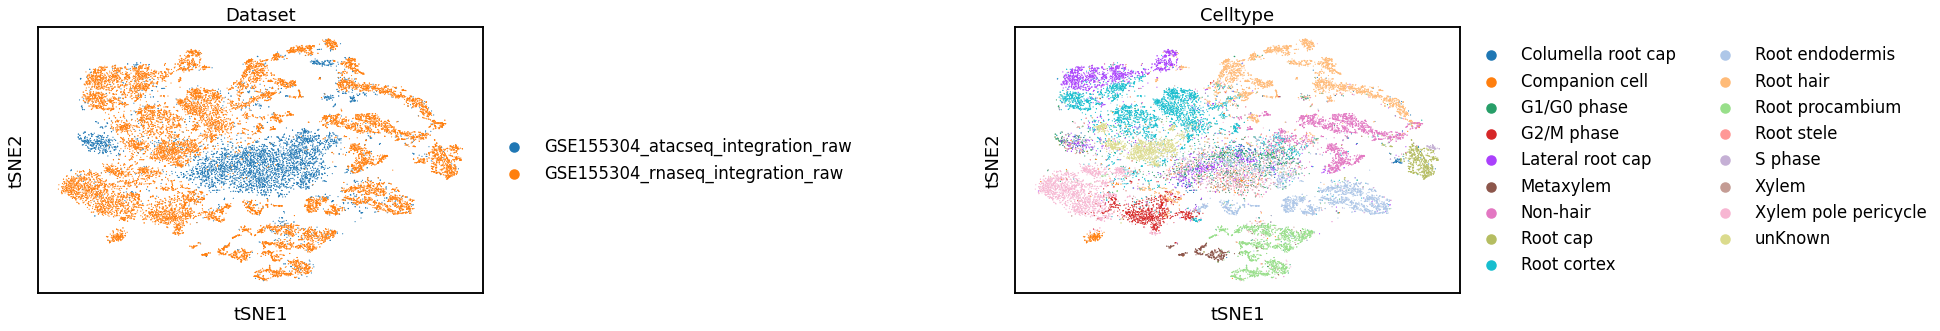

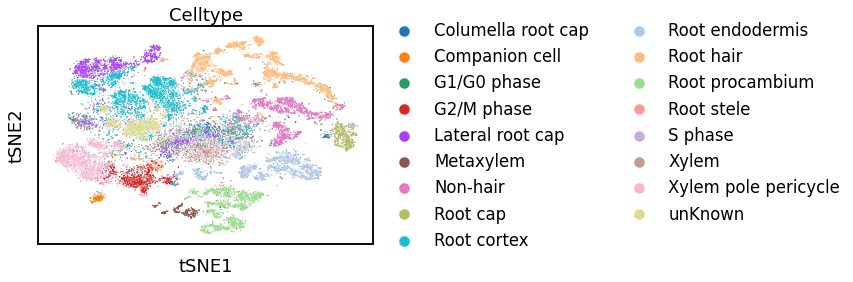

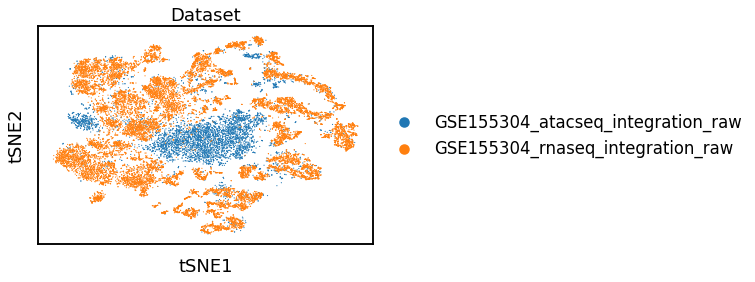

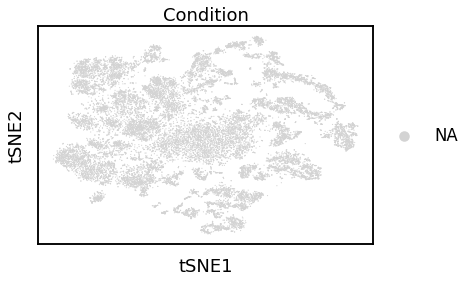

In [18]:
sc.pl.tsne(adata_mod1, color=["Dataset", "Celltype"], wspace=1,save= data_name + use_rep_name + '_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Celltype"], wspace=1,save= data_name + use_rep_name + 'Celltype_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Dataset"], wspace=1,save= data_name + use_rep_name + 'experiments_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Condition"], wspace=1,save= data_name + use_rep_name + 'Condition_tsne_plot.pdf')

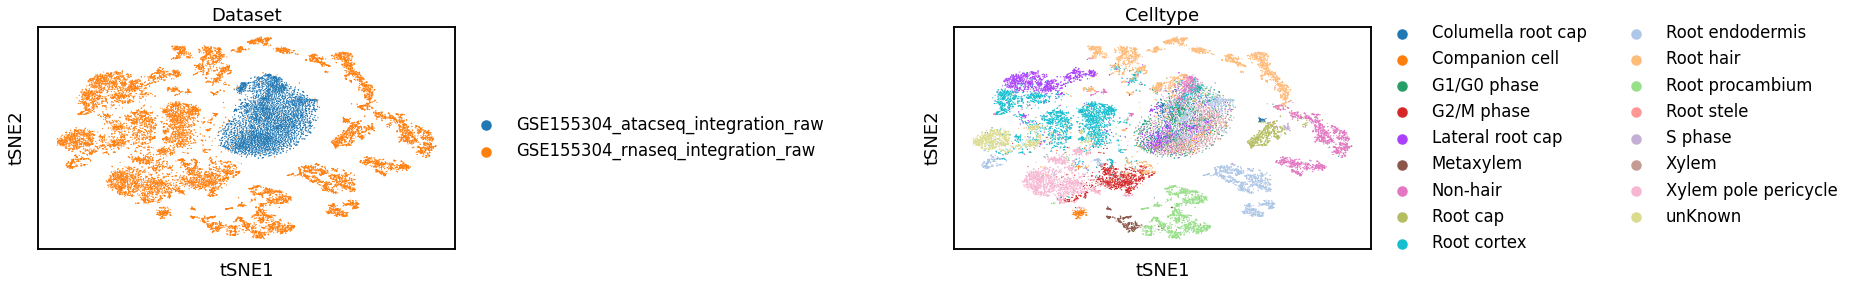

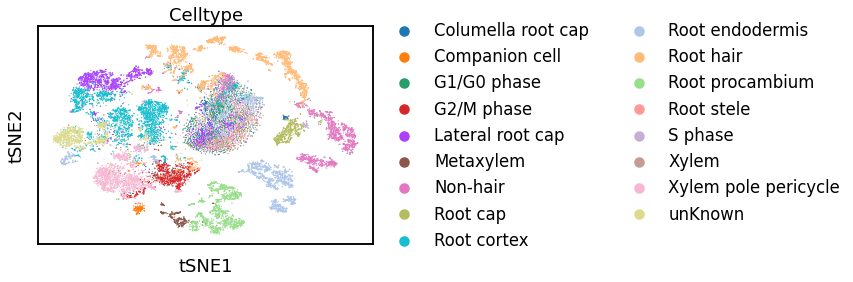

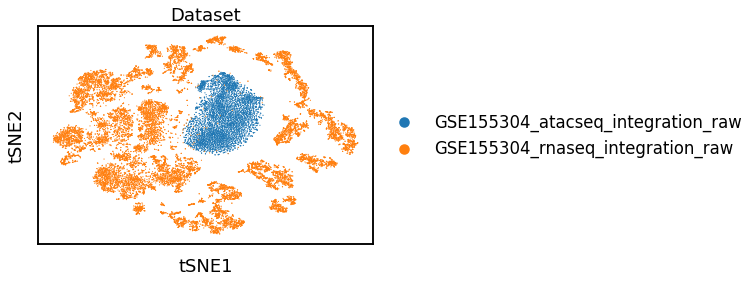

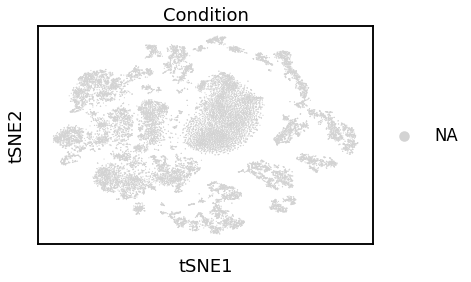

In [19]:
use_rep_name = "X_scmGPT_5000.0"
sc.tl.tsne(adata_mod1, use_rep=use_rep_name)
sc.pl.tsne(adata_mod1, color=["Dataset", "Celltype"], wspace=1,save= data_name + use_rep_name + '_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Celltype"], wspace=1,save= data_name + use_rep_name + 'Celltype_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Dataset"], wspace=1,save= data_name + use_rep_name + 'experiments_tsne_plot.pdf')
sc.pl.tsne(adata_mod1, color=["Condition"], wspace=1,save= data_name + use_rep_name + 'Condition_tsne_plot.pdf')

In [1]:
import scanpy as sc

C:\D\software\conda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\D\software\conda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
adata = sc.read("GSE155304_integration_raw_loss1=1_dp=0.0_epoch=3_lr=1e-4_bs=256_alldata_allgene.h5ad")

In [3]:
adata.obs["Dataset"].value_counts()

Dataset
GSE155304_rnaseq_integration_raw     17985
GSE155304_atacseq_integration_raw     4764
Name: count, dtype: int64